In [ ]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter

import numpy
import pandas
from math import exp, sqrt, log

from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from sklearn.externals import joblib

from importlib import reload
from matplotlib import pyplot as plt
from random import random, shuffle, choice, randint

from classes import Student, Question
from utils import generate_student_name, create_qs, create_students, generate_attempts, calculate_pass_probability, attempt_q

import random
import math
import scipy

from NN_utils import BigTable, WeightClip

print("started")

use_saved = True
do_train = True
do_testing = True
create_scorecards = True

base = "../../../isaac_data_files/"

from scipy.optimize import curve_fit
def gompertz(x, A,k1,k2,off):
    return A*numpy.exp(-k1*numpy.exp(-k2*(x-off)))

def inv_gompertz(y, A,k1,k2,off):
    return off + numpy.log(k1/numpy.log(A/y))/k2

def logistic(x, b,off):
    return 1/(1+(numpy.exp(-b*(x-off))))

# p = 1/(1+e(-x))
# 1+e(-x) = 1/p
# e(-x) = (1/p)-1
# x = -log((1/p)-1)

def inv_logistic(pr, b,off):
    return off-(numpy.log((1/pr) -1))/b

sigmoid = lambda z: 1/(1+(numpy.exp(-z)))
def pr(a,d): return sigmoid((a-d))
def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/comps)
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

def spread_to_pr(sp, comps=1):
    return numpy.power((1/(1+numpy.exp(-sp))), comps)

In [ ]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students(n_students, a0, a1, n_factors, gen_mode="truncnorm"):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.repeat(3, n_factors)
        if gen_mode=="truncnorm":
            true_comps = numpy.random.normal(a0, a1, size=n_factors)
            true_comps = numpy.clip(true_comps,6,12)
        elif gen_mode=="uniform":
            clip0 = a0 - a1*3
            clip1 = a0 + a1*3
            true_comps = numpy.random.uniform(clip0, clip1, size=n_factors)
        else:
            print("unknown distro mode")
        print("True comps", a0,a1, true_comps)
#         true_comps = numpy.random.uniform(a0-3*a1, a0+3*a1, size=n_factors)
#         true_comps = numpy.repeat(3, n_factors)
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c
    return students

def gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode="truncnorm"):
    #approximate the min and max outputs from the gaussian
    inv_fn = spread_to_pr
    av_c = (min_active_traits + max_active_traits)/2
    p = numpy.linspace(0.001,0.999,30)
    sprd = pr_to_spread(p, av_c, as_A_and_D=False)
#     plt.scatter(sprd,p)
#     plt.show()
#     popt, pcov = curve_fit(inv_fn, p, sprd)
#     print(popt)
#     p = numpy.linspace(0.001,0.999,50)
#     d = (p, comps=av_c)
    p2 = spread_to_pr(sprd, av_c)
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    d99 = pr_to_spread(.999, av_c, as_A_and_D=False)
    d00 = pr_to_spread(.001, av_c, as_A_and_D=False)
    print("dvals", d00, d50, d99)
    print("inv_logistic curve")
    plt.scatter(sprd,p)
    plt.plot(sprd,p2)
    plt.show()
    print("tru spread d50=",d50, "(prob={})".format(spread_to_pr(d50, av_c)))
    
    minval = math.inf
    
    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
        n_comps = random_integers(min_active_traits, max_active_traits)
        print("NCOMPS", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        
        mu = a0
        sd = a1
        clip_a, clip_b = 0.0001,0.9999
#         a, b = (clip_a - mu) / sd, (clip_b - mu) / sd
#         standard_probs = scipy.stats.norm.rvs(loc=.5, scale=1/6, size=n_comps)
        if gen_mode == "u_uniform":
#             true_comps = numpy.random.uniform((mu-3*sd)-d99, (mu+3*sd)-d00, size=n_comps)
            true_comps = numpy.random.uniform(mu-d99, mu-d00, size=n_comps)
#             print("true q comps", true_comps)
        elif gen_mode == "c50":
            true_comps = numpy.repeat(mu-d50, n_comps)
        else:
            standard_probs=[]
            if gen_mode == "truncnorm":
                standard_probs = numpy.random.normal(loc=0.5, scale=1/6, size=n_comps)
                standard_probs = numpy.clip(standard_probs,clip_a,clip_b)
            elif gen_mode == "beta22":
                standard_probs = numpy.random.beta(2,2, size=n_comps)# normal(loc=.5, scale=1/6, size=n_comps)
    #         standard_probs = truncnorm.rvs(clip_a, clip_b, loc=mu, scale=sd, size=n_comps)
            elif gen_mode == "uniform":
                standard_probs = numpy.random.uniform(clip_a, clip_b, size=n_comps)
#         standard_probs = numpy.repeat(0.5, n_comps)
            true_comps = a0 - pr_to_spread(standard_probs, comps=n_comps, as_A_and_D=False)
            print(standard_probs,"-->",true_comps)
        
        this_min = min(true_comps)
        if this_min < minval:
            minval= this_min
        
#         plt.scatter(true_comps, standard_probs)
#         plt.show()
                
#         print("Q comps", true_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
        print("q minval is", minval)
        for cix,c in zip(comp_ixs,true_comps):
            if questions[qix,cix] !=0:
                questions[qix,cix] = questions[qix,cix]# - minval + 1
    return questions, minval

# minb,maxb,mina,maxa =(1.0, 11, 6, 11)
def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, q_gen="uniform"):
    students = gen_students(n_students, a0, a1, n_factors)
    questions, offset = gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode=q_gen)

    questions[questions>0] = questions[questions>0] - offset+6
    students = students - offset+6
    
    sig = lambda z : 1/(1+numpy.exp(-z))
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            zmask = (questions[mi]==0).astype(int)
            deltas = students[vi]-questions[mi]
            prs = sig(deltas)
            prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = numpy.prod(prs)
#             print(vi,mi, numpy.prod(prs))
    return obs, probs, students, questions

        

In [ ]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
n_factors, a0, a1, min_active, max_active = (100, 9, 1, 1, 5)
n_students = 100
n_questions = 100

# mind,maxd, a0,sda, n_factors = (1.0, 4.257960060005227, 4.492513201000301, 11.647587058653233, 100)

# res =gen_run(n_factors, n_students, n_questions, a0, sda, min_active, max_active, None,None)
obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, q_gen="u_uniform")
# print(len(res))
plt.hist(students.flatten(), alpha=0.5)
plt.hist(questions.flatten(), alpha=0.5)
plt.show()
# print(numpy.mean(questions[questions>0]))

plt.hist(probz.flatten())
plt.show()

print(obs.flatten())
print(len(obs.flatten()), sum(obs.flatten()))


In [ ]:
students = gen_students(100, 9, 1, 100)
questions, minval = gen_questions(100, 9, 1, 1,5, gen_mode="uniform")
# plt.hist(questions.flatten())
print(minval)
q2 = questions
q2[q2>0] = q2[q2>0] - minval +6
s2 = students - minval +6
plt.hist(q2.flatten(), alpha=0.5)
plt.hist(s2.flatten(), alpha=0.5)

plt.show()

In [423]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    klip = Lambda(lambda q: K.clip(q,0,1))
    q_masque = klip(qn_row)

#     qn_row = GaussianNoise(.5)(qn_row)
    psi_row = psi_table(psi_sel)
#     psi_row = GaussianNoise(0.5)(psi_row)
    
#     prds = multiply([qn_row, psi_row])
    difs = subtract([psi_row, qn_row])
#     score = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True)/n_factors, name="score")(prds)
    Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
    Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1.0-ps_q[1]) ) ([Prs, q_masque])

    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
#     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
#     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
    five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)))
    one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
    five_loss = 10*five_limit(qn_row)#(qn_table.kernel)
    one_loss = one_limit(qn_row)#(qn_table.kernel)
#     mag_loss = L_2a(qn_table.kernel) #+ five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
    mag_loss = five_loss + one_loss
#     mag_loss = L_2(qn_row)
    
    def ident_loss(outer):
        def inner(t,h):
            return outer
        return inner
    
    
    def custom_loss(mag_loss):
        def orig_loss(yt,yh):
#             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
            if comp_lims:
                return K.mean(K.square(yt-yh)) + mag_loss#/10000 #+mag_loss # (reg_loss+mag_loss)/2
            else:
                return K.mean(K.square(yt-yh))
        return orig_loss
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
#     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
    model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])

    print(model.summary())

    return model

In [424]:
from collections import defaultdict

all_sz = []
all_qz = []
all_pfz = []

# n_factors = 100
# n_students = 1000
# n_questions = 100

frak = 1
pairs_to_use = [(v,m) for v in range(n_students) for m in range(n_questions)]
seenkeys = []
seen = defaultdict(list)
# if frak != 1:
#     all_pair_ixs = list(range(len(all_pairs)))
#     print(all_pairs[0:10])
#     pairs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10000)), replace=True)
#     pairs_to_use = numpy.array(all_pairs)[pairs_to_use]
        
for vi,mi in pairs_to_use:
# #         sc = 1 if (random.random() <= numpy.prod(sig(viewers[vi]-movies[mi]))) else 0
# #         p = numpy.prod(sig(viewers[vi]-movies[mi]))
# #         sc = int(0.5 <= numpy.prod(sig(viewers[vi]-movies[mi])))
#         sc = obs[vi,mi]
        all_sz.append(vi)
        all_qz.append(mi)
#         all_pfz.append(sc)
#         seenkeys.append((vi,mi))
#         seen[(vi,mi)].append(sc)

av_c = (min_active + max_active)/2
inv_sigmoid = lambda p: -numpy.log(1/p - 1)
p50 = inv_sigmoid( 0.5**(1/n_factors) )
print("p50 is ", p50)

s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=7)#, regulariser=regularizers.l1(10e-6))
qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=7-p50)#, regulariser=regularizers.l1(10e-6))



p50 is  4.96821536878


10000/10000 [==============================] - 0s 36us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1590/100000
10000/10000 [==============================] - 0s 34us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1591/100000
10000/10000 [==============================] - 0s 39us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1592/100000
10000/10000 [==============================] - 0s 31us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1593/100000
10000/10000 [==============================] - 0s 29us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1594/100000
10000/10000 [==============================] - 0s 27us/step - loss: 74.9022 - inner: 74.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1595/100000
10000/10000 [==============================] - 0s 29us/step - loss: 74.8989 - inner: 74.8968 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 24us/step - loss: 73.4147 - inner: 73.4126 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1700/100000
10000/10000 [==============================] - 0s 28us/step - loss: 73.4042 - inner: 73.4021 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1701/100000
10000/10000 [==============================] - 0s 28us/step - loss: 73.4021 - inner: 73.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1702/100000
10000/10000 [==============================] - 0s 24us/step - loss: 73.4021 - inner: 73.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1703/100000
10000/10000 [==============================] - 0s 24us/step - loss: 73.4021 - inner: 73.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1704/100000
10000/10000 [==============================] - 0s 28us/step - loss: 73.4021 - inner: 73.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1705/100000
10000/10000 [==============================] - 0s 24us/step - loss: 73.4021 - inner: 73.4000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 25us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1810/100000
10000/10000 [==============================] - 0s 23us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1811/100000
10000/10000 [==============================] - 0s 25us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1812/100000
10000/10000 [==============================] - 0s 30us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1813/100000
10000/10000 [==============================] - 0s 25us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1814/100000
10000/10000 [==============================] - 0s 23us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1815/100000
10000/10000 [==============================] - 0s 24us/step - loss: 72.3020 - inner: 72.3000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 26us/step - loss: 71.4019 - inner: 71.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1920/100000
10000/10000 [==============================] - 0s 30us/step - loss: 71.4019 - inner: 71.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1921/100000
10000/10000 [==============================] - 0s 24us/step - loss: 71.3951 - inner: 71.3931 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1922/100000
10000/10000 [==============================] - 0s 26us/step - loss: 71.3681 - inner: 71.3662 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1923/100000
10000/10000 [==============================] - 0s 24us/step - loss: 71.3493 - inner: 71.3474 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1924/100000
10000/10000 [==============================] - 0s 24us/step - loss: 71.3341 - inner: 71.3322 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 1925/100000
10000/10000 [==============================] - 0s 24us/step - loss: 71.3209 - inner: 71.3190 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 24us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2030/100000
10000/10000 [==============================] - 0s 25us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2031/100000
10000/10000 [==============================] - 0s 31us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2032/100000
10000/10000 [==============================] - 0s 23us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2033/100000
10000/10000 [==============================] - 0s 25us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2034/100000
10000/10000 [==============================] - 0s 23us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2035/100000
10000/10000 [==============================] - 0s 24us/step - loss: 70.2019 - inner: 70.2000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 25us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2140/100000
10000/10000 [==============================] - 0s 23us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2141/100000
10000/10000 [==============================] - 0s 26us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2142/100000
10000/10000 [==============================] - 0s 24us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2143/100000
10000/10000 [==============================] - 0s 24us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2144/100000
10000/10000 [==============================] - 0s 25us/step - loss: 69.1018 - inner: 69.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2145/100000
10000/10000 [==============================] - 0s 27us/step - loss: 69.0834 - inner: 69.0816 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 32us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2250/100000
10000/10000 [==============================] - 0s 31us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2251/100000
10000/10000 [==============================] - 0s 31us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2252/100000
10000/10000 [==============================] - 0s 32us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2253/100000
10000/10000 [==============================] - 0s 32us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2254/100000
10000/10000 [==============================] - 0s 32us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2255/100000
10000/10000 [==============================] - 0s 33us/step - loss: 68.5017 - inner: 68.5000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2360/100000
10000/10000 [==============================] - 0s 24us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2361/100000
10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2362/100000
10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2363/100000
10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2364/100000
10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2365/100000
10000/10000 [==============================] - 0s 23us/step - loss: 67.9017 - inner: 67.9000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2470/100000
10000/10000 [==============================] - 0s 29us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2471/100000
10000/10000 [==============================] - 0s 31us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2472/100000
10000/10000 [==============================] - 0s 30us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2473/100000
10000/10000 [==============================] - 0s 32us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2474/100000
10000/10000 [==============================] - 0s 31us/step - loss: 67.3017 - inner: 67.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2475/100000
10000/10000 [==============================] - 0s 31us/step - loss: 67.2841 - inner: 67.2824 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2580/100000
10000/10000 [==============================] - 0s 30us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2581/100000
10000/10000 [==============================] - 0s 29us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2582/100000
10000/10000 [==============================] - 0s 33us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2583/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2584/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2585/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.4016 - inner: 66.4000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 29us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2690/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2691/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2692/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2693/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2694/100000
10000/10000 [==============================] - 0s 30us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2695/100000
10000/10000 [==============================] - 0s 31us/step - loss: 66.0016 - inner: 66.0000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2800/100000
10000/10000 [==============================] - 0s 30us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2801/100000
10000/10000 [==============================] - 0s 31us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2802/100000
10000/10000 [==============================] - 0s 31us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2803/100000
10000/10000 [==============================] - 0s 30us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2804/100000
10000/10000 [==============================] - 0s 30us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2805/100000
10000/10000 [==============================] - 0s 30us/step - loss: 65.5016 - inner: 65.5000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 23us/step - loss: 64.9110 - inner: 64.9094 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2910/100000
10000/10000 [==============================] - 0s 23us/step - loss: 64.9022 - inner: 64.9006 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2911/100000
10000/10000 [==============================] - 0s 23us/step - loss: 64.9015 - inner: 64.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2912/100000
10000/10000 [==============================] - 0s 23us/step - loss: 64.9015 - inner: 64.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2913/100000
10000/10000 [==============================] - 0s 24us/step - loss: 64.9015 - inner: 64.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2914/100000
10000/10000 [==============================] - 0s 23us/step - loss: 64.9015 - inner: 64.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 2915/100000
10000/10000 [==============================] - 0s 23us/step - loss: 64.9015 - inner: 64.9000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 25us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3020/100000
10000/10000 [==============================] - 0s 25us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3021/100000
10000/10000 [==============================] - 0s 26us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3022/100000
10000/10000 [==============================] - 0s 26us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3023/100000
10000/10000 [==============================] - 0s 25us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3024/100000
10000/10000 [==============================] - 0s 28us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3025/100000
10000/10000 [==============================] - 0s 25us/step - loss: 64.4015 - inner: 64.4000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3130/100000
10000/10000 [==============================] - 0s 32us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3131/100000
10000/10000 [==============================] - 0s 31us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3132/100000
10000/10000 [==============================] - 0s 32us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3133/100000
10000/10000 [==============================] - 0s 31us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3134/100000
10000/10000 [==============================] - 0s 33us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3135/100000
10000/10000 [==============================] - 0s 33us/step - loss: 64.2015 - inner: 64.2000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 32us/step - loss: 64.0014 - inner: 64.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3240/100000
10000/10000 [==============================] - 0s 32us/step - loss: 64.0014 - inner: 64.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3241/100000
10000/10000 [==============================] - 0s 30us/step - loss: 64.0014 - inner: 64.0000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3242/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.9911 - inner: 63.9897 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3243/100000
10000/10000 [==============================] - 0s 30us/step - loss: 63.9636 - inner: 63.9622 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3244/100000
10000/10000 [==============================] - 0s 32us/step - loss: 63.9454 - inner: 63.9439 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3245/100000
10000/10000 [==============================] - 0s 32us/step - loss: 63.9309 - inner: 63.9294 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3350/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3351/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3352/100000
10000/10000 [==============================] - 0s 30us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3353/100000
10000/10000 [==============================] - 0s 34us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3354/100000
10000/10000 [==============================] - 0s 30us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3355/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.9014 - inner: 63.9000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3460/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3461/100000
10000/10000 [==============================] - 0s 34us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3462/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3463/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3464/100000
10000/10000 [==============================] - 0s 37us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3465/100000
10000/10000 [==============================] - 0s 33us/step - loss: 63.8014 - inner: 63.8000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 63.4818 - inner: 63.4804 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3570/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.4559 - inner: 63.4545 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3571/100000
10000/10000 [==============================] - 0s 30us/step - loss: 63.4389 - inner: 63.4375 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3572/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.4248 - inner: 63.4235 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3573/100000
10000/10000 [==============================] - 0s 32us/step - loss: 63.4126 - inner: 63.4113 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3574/100000
10000/10000 [==============================] - 0s 30us/step - loss: 63.4027 - inner: 63.4014 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3575/100000
10000/10000 [==============================] - 0s 31us/step - loss: 63.4013 - inner: 63.4000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 62.8013 - inner: 62.8000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3680/100000
10000/10000 [==============================] - 0s 31us/step - loss: 62.7868 - inner: 62.7855 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3681/100000
10000/10000 [==============================] - 0s 30us/step - loss: 62.7608 - inner: 62.7594 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3682/100000
10000/10000 [==============================] - 0s 31us/step - loss: 62.7440 - inner: 62.7427 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3683/100000
10000/10000 [==============================] - 0s 31us/step - loss: 62.7298 - inner: 62.7285 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3684/100000
10000/10000 [==============================] - 0s 29us/step - loss: 62.7174 - inner: 62.7160 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3685/100000
10000/10000 [==============================] - 0s 30us/step - loss: 62.7060 - inner: 62.7047 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 33us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3790/100000
10000/10000 [==============================] - 0s 31us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3791/100000
10000/10000 [==============================] - 0s 44us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3792/100000
10000/10000 [==============================] - 0s 33us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3793/100000
10000/10000 [==============================] - 0s 30us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3794/100000
10000/10000 [==============================] - 0s 42us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3795/100000
10000/10000 [==============================] - 0s 36us/step - loss: 62.3013 - inner: 62.3000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 62.0605 - inner: 62.0593 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3900/100000
10000/10000 [==============================] - 0s 31us/step - loss: 62.0337 - inner: 62.0324 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3901/100000
10000/10000 [==============================] - 0s 30us/step - loss: 62.0074 - inner: 62.0061 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3902/100000
10000/10000 [==============================] - 0s 29us/step - loss: 61.9657 - inner: 61.9645 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3903/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.9157 - inner: 61.9144 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3904/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.8803 - inner: 61.8790 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 3905/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.8516 - inner: 61.8503 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 32us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4010/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4011/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4012/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4013/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4014/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4015/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.3012 - inner: 61.3000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 61.1724 - inner: 61.1712 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4120/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.1445 - inner: 61.1433 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4121/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.1208 - inner: 61.1196 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4122/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.1071 - inner: 61.1059 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4123/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.1012 - inner: 61.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4124/100000
10000/10000 [==============================] - 0s 31us/step - loss: 61.1012 - inner: 61.1000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4125/100000
10000/10000 [==============================] - 0s 30us/step - loss: 61.1012 - inner: 61.1000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 29us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4230/100000
10000/10000 [==============================] - 0s 34us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4231/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4232/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4233/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4234/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4235/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.9012 - inner: 60.9000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 33us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4340/100000
10000/10000 [==============================] - 0s 32us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4341/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4342/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4343/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4344/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4345/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.6012 - inner: 60.6000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 60.3375 - inner: 60.3363 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4450/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.3244 - inner: 60.3232 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4451/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.3127 - inner: 60.3115 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4452/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.3028 - inner: 60.3017 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4453/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.3012 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4454/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.3012 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4455/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.3012 - inner: 60.3000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4560/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4561/100000
10000/10000 [==============================] - 0s 32us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4562/100000
10000/10000 [==============================] - 0s 30us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4563/100000
10000/10000 [==============================] - 0s 29us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4564/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4565/100000
10000/10000 [==============================] - 0s 31us/step - loss: 60.3011 - inner: 60.3000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4670/100000
10000/10000 [==============================] - 0s 32us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4671/100000
10000/10000 [==============================] - 0s 30us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4672/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4673/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4674/100000
10000/10000 [==============================] - 0s 32us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4675/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4780/100000
10000/10000 [==============================] - 0s 30us/step - loss: 59.9011 - inner: 59.9000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4781/100000
10000/10000 [==============================] - 0s 32us/step - loss: 59.8953 - inner: 59.8942 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4782/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.8689 - inner: 59.8678 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4783/100000
10000/10000 [==============================] - 0s 32us/step - loss: 59.8505 - inner: 59.8494 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4784/100000
10000/10000 [==============================] - 0s 29us/step - loss: 59.8354 - inner: 59.8343 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4785/100000
10000/10000 [==============================] - 0s 30us/step - loss: 59.8223 - inner: 59.8212 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 30us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4890/100000
10000/10000 [==============================] - 0s 30us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4891/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4892/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4893/100000
10000/10000 [==============================] - 0s 39us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4894/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 4895/100000
10000/10000 [==============================] - 0s 30us/step - loss: 59.4011 - inner: 59.4000 - inner_1: 0.0000e+00 - a

10000/10000 [==============================] - 0s 31us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5000/100000
10000/10000 [==============================] - 0s 34us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5001/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5002/100000
10000/10000 [==============================] - 0s 33us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5003/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5004/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - acc: 0.0017
Epoch 5005/100000
10000/10000 [==============================] - 0s 31us/step - loss: 59.3011 - inner: 59.3000 - inner_1: 0.0000e+00 - a

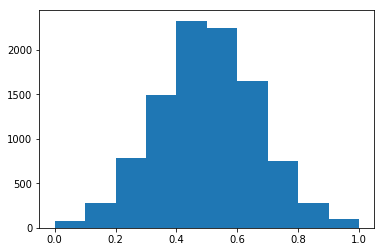

In [429]:
# setup_vals = numpy.random.beta(2,2, size=(n_students*n_questions))
setup_vals = numpy.random.normal(0.5, 1/6, size=(n_students*n_questions))
setup_vals = numpy.clip(setup_vals, 0,1)
plt.hist(setup_vals)
from keras.callbacks import EarlyStopping
print(len(all_qz), len(all_sz))
# wz = m.get_weights()
m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=True)
# m.set_weights(wz)
es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
m.fit(x=[all_qz,all_sz], y=numpy.array(setup_vals).reshape(-1,1), batch_size=100, shuffle=True, epochs=100000, verbose=1, callbacks=[es])

In [426]:
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
print(qws)
# print(sws)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    4.95  0.    0.    0.
   0.    0.    2.12  0.    0.    0.    0.    2.85  0.    0.    0.    4.5
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   3.84  0.    0.    4.28  0.    0.    0.    0.    0.    0.    0.    0.    0.
   5.31  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    4.03  0.    5.45  0.    0.    0.    0.    5.53  0.    6.36  0.
   2.86  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    6.34  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    5.56  0.    0.    0.    0.    0.    0.    0.    0.
   2.06  4.11  1.68  0.    4.42  0.    0.    0.    2.94  0.    0.    3.26
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   4.45  0.    0.    0.    4.27  0.    0.    0.    0.    7.36  0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    4.88  0.    0.    0.
   0.    0.    0.    0

0.0 1.0044 14.3564
6.0 20.748


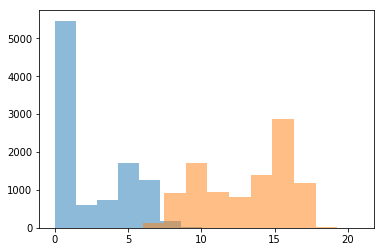

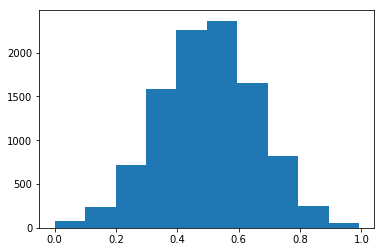

OBS SSHAPE (100, 100)
tvt: 10000 9000 1000
len all_pfz 10000
9000 [ 4560.]


In [420]:
print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qws))
print(numpy.min(sws), numpy.max(sws))

plt.hist(qws.flatten(), alpha=0.5)
plt.hist(sws.flatten(), alpha=0.5)
plt.show()

sig = lambda z : 1/(1+numpy.exp(-z))
obs = numpy.zeros((len(sws), len(qws)))
probs = numpy.zeros((len(sws), len(qws)))
#obs = numpy.matmul(viewers, movies.T)/n_factors
vz = []
mz = []
scz =[]
for vi in range(len(sws)):
    for mi in range(len(qws)):
        zmask = (qws[mi]<1).astype(int)
        deltas = sws[vi]-qws[mi]
        prs = sig(deltas)
        prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
        pr = numpy.prod(prs)
        obs[vi,mi] = (random.random() < pr)
        probs[vi,mi] = numpy.prod(prs)
#             print(vi,mi, numpy.prod(prs))

plt.hist(probs.flatten())
plt.show()

print("OBS SSHAPE", obs.shape)

all_pfz=obs

frak=1
all_pairs = [(s,q) for s,q in zip(all_sz,all_qz)]
all_pair_ixs = list(range(len(all_pairs)))
# ixs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10)), replace=True)
# pairs_to_use = numpy.array(all_pairs)[ixs_to_use]

all_ixs = all_pair_ixs
val_ixs = numpy.random.choice(all_pair_ixs, size=int(len(all_pair_ixs)/10), replace=False) #len(attempts)//100, replace=False)
trn_ixs = list(set(all_ixs) - set(val_ixs))
test_ixs = val_ixs
print("tvt:", len(all_ixs), len(trn_ixs), len(test_ixs))

all_sz = numpy.array(all_sz).reshape([-1,1])
all_qz = numpy.array(all_qz).reshape([-1,1])
all_pfz = numpy.array(all_pfz).reshape([-1,1])
print("len all_pfz", len(all_pfz))

tsz = all_sz[test_ixs]
tqz = all_qz[test_ixs]
tpfz = all_pfz[test_ixs]

sz = all_sz[trn_ixs]
qz = all_qz[trn_ixs]
pfz = all_pfz[trn_ixs]


print(len(pfz), sum(pfz))

0.0 6.0 14.5556326859
6.0 12.0
---
0.0 1.00788 9.02509
6.0 16.538
[[ 0.    0.    0.    0.    0.    0.    4.39  0.    0.    0.    0.    3.93
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    4.65  0.    0.    3.03  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    2.74  4.3   0.    0.    3.78  0.    0.    0.    5.08  0.    0.
   6.14  0.    0.    7.47  3.98  0.    0.    0.    2.4   0.    0.  ]
 [ 0.    7.39  4.58  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    3.79  0.    2.07  0.    0.    0.    0.    0.    0.    0.    0.
   1.19  4.82  0.    0.    0.    0.    0.    0.    0.    0.    4.55  0.    0.
   4.56  0.    0.    0.    1.69  0.    0.    0.    0.    5.39  0.    0.    0.
   0.    0.    0.

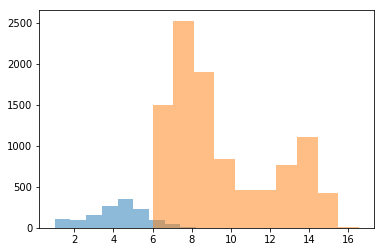

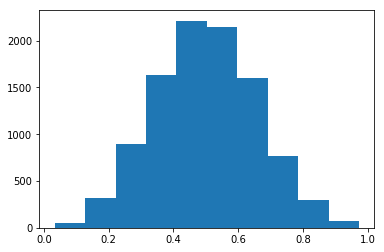

In [421]:
print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("---")
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(sws), numpy.max(s_table.get_weights()[0]))

import sys
numpy.set_printoptions(precision=2, suppress=True, threshold=sys.maxsize)

print(qws)

plt.hist(qws[qws>=1].flatten(), alpha=0.5)
plt.hist(sws.flatten(), alpha=0.5)
plt.show()

sig = lambda z : 1/(1+numpy.exp(-z))
obs = numpy.zeros((len(sws), len(qws)))
probs = numpy.zeros((len(sws), len(qws)))
#obs = numpy.matmul(viewers, movies.T)/n_factors
vz = []
mz = []
scz =[]
for vi in range(len(sws)):
    for mi in range(len(qws)):
        zmask = (qws[mi]<1).astype(int)
        deltas = sws[vi]-qws[mi]
        prs = sig(deltas)
        prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
        pr = numpy.prod(prs)
        obs[vi,mi] = (random.random() < pr)
        probs[vi,mi] = numpy.prod(prs)
#             print(vi,mi, numpy.prod(prs))

plt.hist(probs.flatten())
plt.show()

In [427]:
for ix in range(len(qws)):
    flags = (qws[ix]>1).astype(int) 
    print(flags, sum(flags))
# print((qws>=1).astype(int))

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] 13
[0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] 14
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] 11
[0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 11
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
for vi,mi,sc in zip(all_sz,all_qz,all_pfz):
    print(vi,mi,sc)

In [ ]:
# sw = s_table.get_weights()[0]
# qw = qn_table.get_weights()[0]

# print(sw.shape)
# print(qw.shape)

# mm = numpy.dot(qw, sw.T)/n_factors
# # mm = numpy.sum(mm, axis=1)
# print(mm)


In [267]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
initpfz = [0.5 for _ in range(len(pfz))]
m.fit(x=[qz,sz], y=numpy.array(initpfz).reshape(-1,1), batch_size=1000, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_split=1000/len(initpfz))

Train on 8000 samples, validate on 1000 samples
Epoch 1/1000
8000/8000 [==============================] - 1s 118us/step - loss: 0.0368 - acc: 0.0000e+00 - val_loss: 0.0373 - val_acc: 0.0000e+00
Epoch 2/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0364 - acc: 0.0000e+00 - val_loss: 0.0372 - val_acc: 0.0000e+00
Epoch 3/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0354 - acc: 0.0000e+00 - val_loss: 0.0376 - val_acc: 0.0000e+00
Epoch 4/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0344 - acc: 0.0000e+00 - val_loss: 0.0368 - val_acc: 0.0000e+00
Epoch 5/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0337 - acc: 0.0000e+00 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 6/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0328 - acc: 0.0000e+00 - val_loss: 0.0365 - val_acc: 0.0000e+00
Epoch 7/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0322 -

8000/8000 [==============================] - 0s 10us/step - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 114/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 115/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0172 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 116/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0172 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 117/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0172 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 118/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0171 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 119/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0171 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.

8000/8000 [==============================] - 0s 8us/step - loss: 0.0140 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 226/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0140 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 227/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 228/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 229/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 230/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 231/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0

8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 338/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 339/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 340/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 341/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 342/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 343/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.00

8000/8000 [==============================] - 0s 7us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 450/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 451/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 452/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 453/1000
8000/8000 [==============================] - 0s 6us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 454/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 455/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.00

8000/8000 [==============================] - 0s 11us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 562/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 563/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 564/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 565/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 566/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 567/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0

8000/8000 [==============================] - 0s 10us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 674/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 675/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 676/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 677/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 678/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 679/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0109 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0

8000/8000 [==============================] - 0s 9us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 786/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 787/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 788/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 789/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 790/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 791/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.00

8000/8000 [==============================] - 0s 7us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 898/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 899/1000
8000/8000 [==============================] - 0s 8us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 900/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 901/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 902/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 903/1000
8000/8000 [==============================] - 0s 7us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.00

In [268]:
print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("---")
qws = qn_table.get_weights()[0]
print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))

print(qws)

0.0 6.0 16.7617400138
6.0 12.0
---
0.0 1.88467 10.0476
6.0 17.289
[[  0.     0.01   0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.01   0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.01   0.     0.     3.55   0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.02   0.
    0.01   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.02   0.     0.     0.09   0.     0.     0.     0.01   0.     0.
    0.     0.     0.     0.02   0.     0.     0.     0.     0.     0.
    0.01   0.     0.02   0.     0.     0.     0.     8.79   0.     0.
    4.02   0.     0.     0.  ]
 [  0.     0.35   0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    7.19   0.     0.     0.03   0.     0.     0.16   0.     0.     0.     0.
    0. 

In [288]:
preds = m.predict(x=[qz,sz])
for sc_true, sc_hat in zip(pfz[0:100],preds[0:100]):
    print(sc_true, sc_hat)

# print(m.evaluate(x=[mz,vz], y=scz))
from sklearn.metrics import accuracy_score, mean_absolute_error
print(accuracy_score(numpy.around(pfz), numpy.around(preds)  ))

[ 0.] [ 0.41]
[ 0.] [ 0.48]
[ 0.] [ 0.46]
[ 1.] [ 0.58]
[ 1.] [ 0.56]
[ 0.] [ 0.58]
[ 1.] [ 0.65]
[ 1.] [ 0.73]
[ 0.] [ 0.57]
[ 0.] [ 0.61]
[ 0.] [ 0.21]
[ 1.] [ 0.31]
[ 1.] [ 0.42]
[ 0.] [ 0.25]
[ 0.] [ 0.38]
[ 0.] [ 0.41]
[ 0.] [ 0.43]
[ 0.] [ 0.63]
[ 0.] [ 0.47]
[ 0.] [ 0.52]
[ 1.] [ 0.69]
[ 1.] [ 0.54]
[ 1.] [ 0.52]
[ 1.] [ 0.55]
[ 1.] [ 0.67]
[ 1.] [ 0.61]
[ 1.] [ 0.47]
[ 1.] [ 0.51]
[ 0.] [ 0.63]
[ 1.] [ 0.76]
[ 0.] [ 0.25]
[ 0.] [ 0.52]
[ 1.] [ 0.7]
[ 1.] [ 0.78]
[ 1.] [ 0.66]
[ 1.] [ 0.48]
[ 0.] [ 0.29]
[ 0.] [ 0.35]
[ 0.] [ 0.34]
[ 0.] [ 0.4]
[ 1.] [ 0.36]
[ 1.] [ 0.42]
[ 1.] [ 0.31]
[ 1.] [ 0.92]
[ 0.] [ 0.29]
[ 1.] [ 0.32]
[ 0.] [ 0.44]
[ 0.] [ 0.64]
[ 0.] [ 0.46]
[ 1.] [ 0.57]
[ 1.] [ 0.74]
[ 0.] [ 0.74]
[ 0.] [ 0.74]
[ 0.] [ 0.51]
[ 1.] [ 0.69]
[ 1.] [ 0.58]
[ 1.] [ 0.67]
[ 1.] [ 0.56]
[ 0.] [ 0.59]
[ 0.] [ 0.44]
[ 1.] [ 0.4]
[ 0.] [ 0.3]
[ 0.] [ 0.57]
[ 0.] [ 0.47]
[ 0.] [ 0.59]
[ 0.] [ 0.56]
[ 0.] [ 0.54]
[ 0.] [ 0.17]
[ 0.] [ 0.42]
[ 0.] [ 0.42]
[ 0.] [ 0.23]
[ 1.] [ 0.

In [298]:
from keras.callbacks import EarlyStopping

# wz = m.get_weights()
s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False)
# m.set_weights(wz)

es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=25)
m.fit(x=[qz,sz], y=pfz, batch_size=1000, epochs=1000, validation_split=1000/len(pfz), callbacks=[es])

<NN_utils.BigTable object at 0x7fa41a6c2240> <NN_utils.BigTable object at 0x7fa41a6c2b00> Tensor("psi_select_56:0", shape=(?, 1), dtype=int32) Tensor("q_select_56:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (100, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 100)
'rows' shape, (?, 100)
kk (100, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 100)
'rows' shape, (?, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_select (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________

Epoch 98/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.2398 - acc: 0.5896 - val_loss: 0.2537 - val_acc: 0.5130
Epoch 99/1000
8000/8000 [==============================] - 0s 10us/step - loss: 0.2397 - acc: 0.5905 - val_loss: 0.2537 - val_acc: 0.5130


In [296]:
print(len(pfz), len(tpfz))
right_ct=0
preds = m.predict(x=[tqz,tsz])
for sc_obsv, sc_hat in zip(tpfz,preds):
#     if ((sc_obsv==0.5 and abs(sc_obsv-sc_hat)<0.33) or abs(sc_obsv-sc_hat)<0.33):
#         right_ct+=1
#         res = "right"
#     else:
#         res = "X"
    print(sc_obsv, sc_hat, "right" if (numpy.around(sc_obsv)==numpy.around(sc_hat)) else "X")
#     print(sc_obsv, sc_hat, res)

# print(m.evaluate(x=[tmz,tvz], y=tscz))

from sklearn.metrics import accuracy_score, mean_absolute_error
print(preds.shape)

# print(right_ct / len(tpfz))
print("obvsd acc", accuracy_score(numpy.around(tpfz), numpy.around(preds)))
# print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
# print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


9000 1000
[ 0.] [ 0.47] right
[ 1.] [ 0.49] X
[ 0.] [ 0.54] X
[ 0.] [ 0.42] right
[ 1.] [ 0.47] X
[ 0.] [ 0.42] right
[ 0.] [ 0.42] right
[ 1.] [ 0.5] right
[ 1.] [ 0.27] X
[ 1.] [ 0.49] X
[ 1.] [ 0.48] X
[ 0.] [ 0.48] right
[ 0.] [ 0.47] right
[ 1.] [ 0.52] right
[ 0.] [ 0.39] right
[ 0.] [ 0.48] right
[ 0.] [ 0.33] right
[ 1.] [ 0.43] X
[ 0.] [ 0.47] right
[ 1.] [ 0.52] right
[ 0.] [ 0.41] right
[ 1.] [ 0.44] X
[ 1.] [ 0.52] right
[ 1.] [ 0.5] X
[ 0.] [ 0.47] right
[ 1.] [ 0.38] X
[ 0.] [ 0.49] right
[ 1.] [ 0.54] right
[ 1.] [ 0.42] X
[ 0.] [ 0.48] right
[ 0.] [ 0.36] right
[ 1.] [ 0.49] X
[ 1.] [ 0.46] X
[ 1.] [ 0.46] X
[ 0.] [ 0.42] right
[ 0.] [ 0.5] right
[ 1.] [ 0.5] X
[ 0.] [ 0.5] X
[ 0.] [ 0.36] right
[ 1.] [ 0.47] X
[ 1.] [ 0.48] X
[ 0.] [ 0.52] X
[ 0.] [ 0.51] X
[ 0.] [ 0.51] X
[ 0.] [ 0.46] right
[ 0.] [ 0.39] right
[ 0.] [ 0.35] right
[ 1.] [ 0.46] X
[ 1.] [ 0.45] X
[ 1.] [ 0.46] X
[ 0.] [ 0.48] right
[ 1.] [ 0.45] X
[ 1.] [ 0.46] X
[ 0.] [ 0.5] right
[ 1.] [ 0.45] X
[ 1.

[ 0.] [ 0.52] X
[ 0.] [ 0.44] right
[ 1.] [ 0.39] X
[ 1.] [ 0.44] X
[ 1.] [ 0.51] right
[ 1.] [ 0.42] X
[ 1.] [ 0.45] X
[ 1.] [ 0.53] right
[ 0.] [ 0.54] X
[ 1.] [ 0.52] right
[ 1.] [ 0.49] X
[ 1.] [ 0.53] right
[ 1.] [ 0.42] X
[ 1.] [ 0.49] X
[ 0.] [ 0.42] right
[ 0.] [ 0.47] right
[ 0.] [ 0.43] right
[ 1.] [ 0.43] X
[ 1.] [ 0.48] X
[ 1.] [ 0.42] X
[ 1.] [ 0.45] X
[ 0.] [ 0.54] X
[ 0.] [ 0.37] right
[ 0.] [ 0.47] right
[ 0.] [ 0.5] right
[ 1.] [ 0.44] X
[ 0.] [ 0.51] X
[ 1.] [ 0.53] right
[ 1.] [ 0.48] X
[ 1.] [ 0.49] X
[ 1.] [ 0.5] right
[ 1.] [ 0.46] X
[ 1.] [ 0.49] X
[ 1.] [ 0.46] X
[ 1.] [ 0.54] right
[ 0.] [ 0.59] X
[ 1.] [ 0.51] right
[ 0.] [ 0.48] right
[ 1.] [ 0.51] right
[ 0.] [ 0.41] right
[ 1.] [ 0.5] X
[ 0.] [ 0.46] right
[ 1.] [ 0.49] X
[ 0.] [ 0.47] right
[ 0.] [ 0.43] right
[ 0.] [ 0.48] right
[ 1.] [ 0.5] X
[ 1.] [ 0.45] X
[ 1.] [ 0.47] X
[ 0.] [ 0.45] right
[ 0.] [ 0.5] right
[ 0.] [ 0.45] right
[ 0.] [ 0.52] X
[ 1.] [ 0.49] X
[ 1.] [ 0.51] right
[ 0.] [ 0.55] X
[ 1.]

0.0 6.0 16.6164914774
6.0 12.0
---
0.0 1.00032 10.1379
6.0 18.0149
[[  1.31462240e+00   7.82334089e-01   9.32355993e-04 ...,   1.87579036e-01
    6.48720562e-01   4.25799787e-01]
 [  5.46614170e-01   2.84296840e-01   4.81818207e-02 ...,   4.11244810e-01
    1.17232621e+00   0.00000000e+00]
 [  3.60608399e-02   5.23219204e+00   1.63931280e-01 ...,   3.35171717e-05
    0.00000000e+00   3.11339408e-01]
 ..., 
 [  9.43937823e-02   8.76701474e-01   8.96934271e-01 ...,   6.43221894e-03
    5.71834564e-01   2.06799433e-01]
 [  1.01092458e+00   3.39664556e-02   4.17214441e+00 ...,   3.97692323e-01
    7.21869409e-01   7.73381591e-01]
 [  1.11959314e+00   2.60252468e-02   8.73619556e-01 ...,   1.00694215e+00
    5.52023351e-01   1.19834459e+00]]


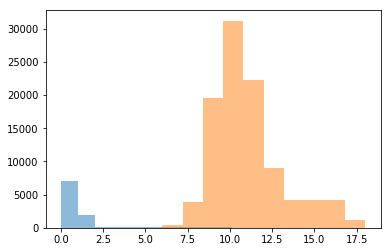

In [57]:
print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("---")
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))

print(qws)

plt.hist(qws.flatten(), alpha=.5)
plt.hist(sws.flatten(), alpha=.5)
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
    print("Threshold:", threshold)
    bool_preds = (preds >= threshold)
    print(confusion_matrix(tpfz, bool_preds))
    print(accuracy_score(tpfz, bool_preds))
    print(" ")

bool_preds = numpy.around(preds)
print("obvsd acc", accuracy_score(tpfz, numpy.around(preds)))
#.8263 v 7814

Threshold: 0.2
[[1137 3924]
 [ 335 4604]]
0.5741
 
Threshold: 0.3
[[1819 3242]
 [ 724 4215]]
0.6034
 
Threshold: 0.4
[[2479 2582]
 [1152 3787]]
0.6266
 
Threshold: 0.5
[[3138 1923]
 [1656 3283]]
0.6421
 
Threshold: 0.6
[[3734 1327]
 [2265 2674]]
0.6408
 
obvsd acc 0.6421


In [ ]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = questions

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = questions

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()